Cell 1 — Install packages

In [1]:
# Install required packages (run once)
%pip install -q mne PyWavelets scikit-learn seaborn imbalanced-learn pandas
%pip install -q azureml-core azure-ai-ml azure-identity

# Print success message
print("✅ Packages installed (if no errors above).")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Packages installed (if no errors above).


Cell 2 — Load libraries + set seeds

In [2]:
# Basic utilities
import os  # For file/folder operations
import random  # For reproducibility
import pickle  # For saving objects (scaler, etc.)

# Arrays
import numpy as np  # Numerical arrays

# Dataframe
import pandas as pd  # For dataset table

# EEG processing
import mne  # EEG toolbox
import pywt  # Wavelet toolbox

# ML tools
from sklearn.decomposition import FastICA  # ICA
from sklearn.model_selection import train_test_split  # Train/val split
from sklearn.preprocessing import StandardScaler  # Feature scaling

# Plotting
import matplotlib.pyplot as plt  # Plotting

# TensorFlow / Keras
import tensorflow as tf  # Deep learning
from tensorflow import keras  # Keras API
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger  # Callbacks

# Set seeds for reproducibility
random.seed(42)  # Python seed
np.random.seed(42)  # NumPy seed
tf.random.set_seed(42)  # TensorFlow seed

# Print confirmation
print("✅ Imports done + seeds set.")


2026-01-28 05:59:31.864003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 05:59:32.050437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769579972.134880   15604 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769579972.154681   15604 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769579972.353198   15604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ Imports done + seeds set.


Cell 3 — Step 1: Import the data

In [3]:
# Azure ML SDK
from azureml.core import Workspace, Datastore, Dataset  # Azure workspace + datastore + dataset

print("[STEP 1] Connecting to Azure ML workspace...")

# Azure workspace parameters (use your existing values)
subscription_id = "eccc04ba-d8b0-4f70-864a-b4a6753bfc72"  # Subscription ID
resource_group  = "somnasnest"  # Resource group
workspace_name  = "SomnasNest"  # Workspace name
folder_path = "UI/2026-01-17_162622_UTC/Data Array/"  # Folder containing .npy files

# Connect to workspace
ws = Workspace.get(
    name=workspace_name,
    subscription_id=subscription_id,
    resource_group=resource_group
)
print("[STEP 1] Workspace connected ✅")

# Load default datastore
datastore = ws.get_default_datastore()
print("[STEP 1] Default datastore loaded ✅")

# Create dataset from files
ds = Dataset.File.from_files(path=(datastore, folder_path))
print("[STEP 1] FileDataset created ✅")

# Create local directory for download
local_dir = "./_ad_data_array"
os.makedirs(local_dir, exist_ok=True)
print(f"[STEP 1] Downloading data to: {local_dir} ...")

# Download files
ds.download(target_path=local_dir, overwrite=True)
print("[STEP 1] Download complete ✅")

# Load .npy arrays
arrays = {}  # Dictionary to store arrays
print("[STEP 1] Loading .npy files...")

for root, _, files in os.walk(local_dir):  # Walk through local folder
    for f in files:  # Loop files
        p = os.path.join(root, f)  # Full path
        if f.lower().endswith(".npy"):  # Only .npy files
            arrays[f] = np.load(p, allow_pickle=False)  # Load numpy file

# Validate existence
if "ad_negative.npy" not in arrays or "ad_positive.npy" not in arrays:
    raise FileNotFoundError("❌ Missing ad_negative.npy or ad_positive.npy in downloaded folder.")

# Load arrays as-is (NO dropping)
X_neg = arrays["ad_negative.npy"].astype(np.float32)  # Shape: (Nneg, C, T)
X_pos = arrays["ad_positive.npy"].astype(np.float32)  # Shape: (Npos, C, T)

print("✅ Arrays loaded (as-is):")
print("  ad_negative.npy:", X_neg.shape, X_neg.dtype)
print("  ad_positive.npy:", X_pos.shape, X_pos.dtype)

# Create labels
y_neg = np.zeros((X_neg.shape[0],), dtype=np.int32)  # 0 for negative
y_pos = np.ones((X_pos.shape[0],), dtype=np.int32)  # 1 for positive

# Combine dataset
X_all_trials = np.concatenate([X_neg, X_pos], axis=0)  # Combine trials
y_all_trials = np.concatenate([y_neg, y_pos], axis=0)  # Combine labels

print("[STEP 1] Combined dataset ✅")
print("  X_all_trials:", X_all_trials.shape)
print("  y_all_trials:", y_all_trials.shape)
print("  Class counts:", dict(zip(*np.unique(y_all_trials, return_counts=True))))


[STEP 1] Connecting to Azure ML workspace...
[STEP 1] Workspace connected ✅
[STEP 1] Default datastore loaded ✅
[STEP 1] FileDataset created ✅
[STEP 1] Downloading data to: ./_ad_data_array ...
{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[STEP 1] Download complete ✅
[STEP 1] Loading .npy files...
✅ Arrays loaded (as-is):
  ad_negative.npy: (31, 127, 150000) float32
  ad_positive.npy: (46, 127, 150000) float32
[STEP 1] Combined dataset ✅
  X_all_trials: (77, 127, 150000)
  y_all_trials: (77,)
  Class counts: {np.int32(0): np.int64(31), np.int32(1): np.int64(46)}


Class DeploymentTemplateOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Cell 4 — Step 2: Downsample to 500 Hz

In [4]:
print("[STEP 2] Downsampling started...")

# Sampling rate assumptions
sfreq_in = 1000  # Input sampling rate
sfreq_out = 500  # Output sampling rate

# Ensure downsample factor is integer
down_factor = int(sfreq_in // sfreq_out)  # Compute factor (1000->500 means 2)
if sfreq_in % sfreq_out != 0:
    raise ValueError("❌ sfreq_in must be an integer multiple of sfreq_out for this resample method.")

print(f"[STEP 2] Resampling from {sfreq_in} Hz to {sfreq_out} Hz (down={down_factor}) ...")

# Resample along the time axis (-1)
X_all_trials_ds = mne.filter.resample(
    X_all_trials.astype(np.float64, copy=False),  # MNE prefers float64 internally
    down=down_factor,  # Downsample factor
    npad="auto",  # Padding
    axis=-1,  # Resample along time axis
    verbose=True  # Print internal info
).astype(np.float32, copy=False)  # Back to float32

print("[STEP 2] Downsampling complete ✅")
print("  Before:", X_all_trials.shape, X_all_trials.dtype)
print("  After :", X_all_trials_ds.shape, X_all_trials_ds.dtype)

# Replace working variable
X_all_trials = X_all_trials_ds  # Update main dataset
fs = float(sfreq_out)  # Update sampling frequency
print(f"[STEP 2] Updated fs = {fs} Hz ✅")


[STEP 2] Downsampling started...
[STEP 2] Resampling from 1000 Hz to 500 Hz (down=2) ...
[STEP 2] Downsampling complete ✅
  Before: (77, 127, 150000) float32
  After : (77, 127, 75000) float32
[STEP 2] Updated fs = 500.0 Hz ✅


Cell 5 — Step 3: Preprocessing classes

In [5]:
# Helper: build channel names
def _names_from_index_mapping(n_channels, index_to_name):
    # If no map is provided, auto-generate names
    if index_to_name is None:
        return [f"EEG{i+1}" for i in range(n_channels)]
    # Detect whether mapping is 0-based or 1-based
    keys = list(index_to_name.keys())
    is_zero_based = (0 in keys) and (1 not in keys)
    # Build names list
    names = []
    for i in range(n_channels):
        key = i if is_zero_based else (i + 1)
        names.append(index_to_name.get(key, f"EEG{i+1}"))
    return names

# Helper: create an MNE RawArray
def _make_raw(eeg, sfreq, ch_names, use_standard_1020=True):
    # Set channel types (EOG if name starts with EOG)
    ch_types = ['eog' if str(n).upper().startswith("EOG") else 'eeg' for n in ch_names]
    # Create MNE info
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    # Create raw object
    raw = mne.io.RawArray(eeg.astype(np.float32, copy=False), info, verbose=False)

    # Try applying standard montage
    if use_standard_1020:
        try:
            mont = mne.channels.make_standard_montage("standard_1020")
            raw.set_montage(mont, match_case=False, on_missing="ignore")
        except Exception:
            pass

    return raw

# Wavelet-ICA (WICA)
class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10, random_state=42):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.random_state = random_state
        self.ica_ = None

    def fit(self, X):
        # Wavelet decomposition
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]  # Approximation coefficients
        # ICA on approximation coefficients
        k = int(min(self.n_components, X.shape[0]))
        self.ica_ = FastICA(n_components=k, random_state=self.random_state)
        S = self.ica_.fit_transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T
        coeffs[0] = A_denoised
        _ = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)  # Reconstruct (fit side)
        return self

    def transform(self, X):
        # Ensure fitted
        assert self.ica_ is not None, "WaveletICA not fitted yet."
        # Wavelet decomposition
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        # ICA transform + inverse
        S = self.ica_.transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T
        coeffs[0] = A_denoised
        # Reconstruct
        Y = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)

        # Fix length mismatch if any
        if Y.shape[1] < X.shape[1]:
            Y = np.pad(Y, ((0, 0), (0, X.shape[1] - Y.shape[1])), mode="constant")
        elif Y.shape[1] > X.shape[1]:
            Y = Y[:, :X.shape[1]]

        return Y.astype(np.float32, copy=False)

# Main EEG preprocessor
class EEGPreprocessor:
    def __init__(
        self,
        *,
        index_to_name=None,
        use_standard_1020=True,
        notch_freqs=(50.0, 100.0, 150.0),
        highpass=0.05,
        bad_point_z=6.0,
        car=True,
        use_wica=True,
        wica_components=10,
        wica_wavelet="db4",
        wica_level=3,
        wica_random_state=42
    ):
        self.index_to_name = index_to_name
        self.use_standard_1020 = use_standard_1020
        self.notch_freqs = notch_freqs
        self.highpass = highpass
        self.bad_point_z = bad_point_z
        self.car = car
        self.use_wica = use_wica

        # Train stats (for transient repair)
        self._train_mu = None
        self._train_sd = None

        # WICA object
        self._wica = WaveletICA(
            wavelet=wica_wavelet,
            level=wica_level,
            n_components=wica_components,
            random_state=wica_random_state
        )

    def _filter_and_reference(self, raw):
        # Apply notch filter
        if self.notch_freqs is not None:
            raw.notch_filter(freqs=list(self.notch_freqs), verbose=False)
        # Apply highpass filter
        if self.highpass is not None:
            raw.filter(l_freq=self.highpass, h_freq=None, verbose=False)
        # Apply common average reference
        if self.car:
            raw.set_eeg_reference("average", projection=True)
            raw.apply_proj()

    def _repair_transients_with_train_stats(self, raw):
        # Get data
        X = raw.get_data()
        # Ensure stats exist
        assert self._train_mu is not None and self._train_sd is not None, "Training stats not set."

        # Compute bounds
        hi = self._train_mu + self.bad_point_z * self._train_sd
        lo = self._train_mu - self.bad_point_z * self._train_sd

        # Mask outliers
        mask = (X > hi) | (X < lo)

        # Repair using interpolation
        if np.any(mask):
            X_fixed = X.copy()
            t = np.arange(X.shape[1], dtype=float)
            for ch in range(X.shape[0]):
                m = mask[ch]
                if m.any():
                    good = ~m
                    if good.sum() >= 2:
                        X_fixed[ch, m] = np.interp(t[m], t[good], X_fixed[ch, good])
            raw._data = X_fixed

    def fit(self, X_train, sfreq):
        # Build channel names
        C = X_train.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)
        # Create raw
        raw_train = _make_raw(X_train, sfreq, ch_names, self.use_standard_1020)
        # Filter + reference
        self._filter_and_reference(raw_train)
        # Compute stats
        Xt = raw_train.get_data()
        self._train_mu = Xt.mean(axis=1, keepdims=True)
        self._train_sd = Xt.std(axis=1, keepdims=True) + 1e-12
        # Fit WICA on training
        if self.use_wica:
            self._wica.fit(Xt)
        return self

    def transform(self, X, sfreq):
        # Build channel names
        C = X.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)
        # Create raw
        raw = _make_raw(X, sfreq, ch_names, self.use_standard_1020)
        # Filter + reference
        self._filter_and_reference(raw)
        # Repair transients using train stats
        self._repair_transients_with_train_stats(raw)
        # Get filtered data
        Xf = raw.get_data()
        # Apply WICA
        if self.use_wica:
            Xf = self._wica.transform(Xf)
        return Xf.astype(np.float32, copy=False)

print("✅ Preprocessing classes loaded.")


✅ Preprocessing classes loaded.


Cell 6 — Step 3: Preprocess all trials

In [6]:
print("[STEP 3] Starting preprocessing...")

# Channel map (keep None if unknown)
CHANNEL_MAP = None  # No mapping provided

# Create preprocessor (same settings as your pipeline)
pre = EEGPreprocessor(
    index_to_name=CHANNEL_MAP,  # Channel name mapping
    use_standard_1020=True,  # Apply montage if possible
    notch_freqs=(50.0, 100.0, 150.0),  # Notch harmonics
    highpass=0.05,  # Highpass cutoff
    bad_point_z=6.0,  # Outlier threshold
    car=True,  # Common average reference
    use_wica=True,  # Wavelet ICA
    wica_components=10,  # ICA components
    wica_wavelet="db4",  # Wavelet name
    wica_level=3,  # Wavelet level
    wica_random_state=42  # Seed
)

# Calibrate on first few trials (same idea as your code)
max_calib_trials = min(10, X_all_trials.shape[0])  # Use first 10 or less
print(f"[STEP 3] Fitting preprocessor on first {max_calib_trials} trials...")

# Concatenate calibration trials along time
calib_trials = X_all_trials[:max_calib_trials]  # Pick trials
X_calib = np.concatenate(calib_trials, axis=1).astype(np.float32, copy=False)  # (C, sumT)

# Fit preprocessor
pre.fit(X_calib, fs)  # Fit stats + WICA
print("[STEP 3] Preprocessor fitted ✅")

# Transform all trials
data_clean = []  # List to store cleaned trials

for i in range(X_all_trials.shape[0]):  # Loop trials
    X_clean = pre.transform(X_all_trials[i], fs)  # Preprocess trial
    data_clean.append(X_clean.astype(np.float32, copy=False))  # Store
    if (i + 1) % 5 == 0 or (i + 1) == X_all_trials.shape[0]:
        print(f"[STEP 3] Preprocessed {i+1}/{X_all_trials.shape[0]} trials...")

# Convert list to array
data_clean = np.array(data_clean, dtype=np.float32)  # (Ntrials, C, T)

print("[STEP 3] Done preprocessing ✅")
print("  data_clean shape:", data_clean.shape)
print("  labels shape    :", y_all_trials.shape)
print("  class counts    :", dict(zip(*np.unique(y_all_trials, return_counts=True))))


[STEP 3] Starting preprocessing...
[STEP 3] Fitting preprocessor on first 10 trials...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
[STEP 3] Preprocessor fitted ✅
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply 

Cell 7 — Step 4: Segment each trial

In [7]:
print("[STEP 4] Segmenting trials into fixed windows...")

# ✅ Recommended segment length for band features
# 2 seconds -> 1000 samples at 500 Hz
segment_seconds = 2.0
segment_size = int(segment_seconds * fs)

print(f"[STEP 4] fs = {fs} Hz")
print(f"[STEP 4] segment_seconds = {segment_seconds} sec")
print(f"[STEP 4] segment_size = {segment_size} samples")

def segment_trial(trial_2d, label, segment_size):
    segments = []  # store EEG segments
    labels = []    # store labels for each segment
    n_segments = trial_2d.shape[1] // segment_size  # number of full segments
    for i in range(n_segments):
        seg = trial_2d[:, i*segment_size:(i+1)*segment_size]  # slice window
        segments.append(seg.astype(np.float32, copy=False))   # save segment
        labels.append(int(label))                             # save same label
    return segments, labels

all_segments = []  # all segments across trials
all_targets = []   # all labels across segments

for idx, (trial, y) in enumerate(zip(data_clean, y_all_trials), start=1):
    segs, ys = segment_trial(trial, y, segment_size)
    all_segments.extend(segs)
    all_targets.extend(ys)
    if idx % 5 == 0 or idx == len(data_clean):
        print(f"[STEP 4] Segmented {idx}/{len(data_clean)} trials...")

all_segments = np.array(all_segments, dtype=np.float32)
all_targets = np.array(all_targets, dtype=np.int32)

print("[STEP 4] Segmentation done ✅")
print("  all_segments shape:", all_segments.shape)
print("  all_targets shape :", all_targets.shape)
print("  class counts      :", dict(zip(*np.unique(all_targets, return_counts=True))))


[STEP 4] Segmenting trials into fixed windows...
[STEP 4] fs = 500.0 Hz
[STEP 4] segment_seconds = 2.0 sec
[STEP 4] segment_size = 1000 samples
[STEP 4] Segmented 5/77 trials...
[STEP 4] Segmented 10/77 trials...
[STEP 4] Segmented 15/77 trials...
[STEP 4] Segmented 20/77 trials...
[STEP 4] Segmented 25/77 trials...
[STEP 4] Segmented 30/77 trials...
[STEP 4] Segmented 35/77 trials...
[STEP 4] Segmented 40/77 trials...
[STEP 4] Segmented 45/77 trials...
[STEP 4] Segmented 50/77 trials...
[STEP 4] Segmented 55/77 trials...
[STEP 4] Segmented 60/77 trials...
[STEP 4] Segmented 65/77 trials...
[STEP 4] Segmented 70/77 trials...
[STEP 4] Segmented 75/77 trials...
[STEP 4] Segmented 77/77 trials...
[STEP 4] Segmentation done ✅
  all_segments shape: (5775, 127, 1000)
  all_targets shape : (5775,)
  class counts      : {np.int32(0): np.int64(2325), np.int32(1): np.int64(3450)}


Cell 8 — Step 4 & 5: Decompose into 5 bands + create 5 features

In [8]:
print("[STEP 5] Band feature extraction (PSD/Welch) started...")

from mne.time_frequency import psd_array_welch  # PSD tool

BANDS = {
    "delta": (0.5, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0)
}

print("[STEP 5] Using bands:", BANDS)
print("[STEP 5] all_segments dtype:", all_segments.dtype)

def band_logpower_features_psd(segment_2d, fs):
    # MNE PSD expects float64
    segment_2d = segment_2d.astype(np.float64, copy=False)

    # segment length
    n_times = segment_2d.shape[1]

    # choose welch params safely
    n_per_seg = min(256, n_times)          # window length
    n_overlap = n_per_seg // 2             # overlap

    # compute PSD for 0.5–45 Hz
    psd, freqs = psd_array_welch(
        segment_2d,
        sfreq=fs,
        fmin=0.5,
        fmax=45.0,
        n_per_seg=n_per_seg,
        n_overlap=n_overlap,
        verbose=False
    )  # psd shape: (C, n_freqs)

    feats = {}

    # compute band power by integrating PSD in each band
    for band_name, (lo, hi) in BANDS.items():
        idx = (freqs >= lo) & (freqs < hi)
        band_power_per_ch = np.trapz(psd[:, idx], freqs[idx], axis=1)  # integrate
        mean_band_power = float(np.mean(band_power_per_ch))            # mean across channels
        feats[band_name] = np.log(mean_band_power + 1e-12)             # log feature

    return feats

feature_rows = []
n_total = all_segments.shape[0]

for i in range(n_total):
    feats = band_logpower_features_psd(all_segments[i], fs)
    feats["target"] = int(all_targets[i])
    feature_rows.append(feats)

    if (i + 1) % 200 == 0 or (i + 1) == n_total:
        print(f"[STEP 5] Processed {i+1}/{n_total} segments...")

import pandas as pd
df = pd.DataFrame(feature_rows)
df = df[["delta", "theta", "alpha", "beta", "gamma", "target"]]

print("[STEP 5] Feature dataset built ✅")
print("  df shape:", df.shape)
print("  class counts:", df["target"].value_counts().to_dict())
print(df.head(10))


[STEP 5] Processed 200/5775 segments...
[STEP 5] Processed 400/5775 segments...
[STEP 5] Processed 600/5775 segments...
[STEP 5] Processed 800/5775 segments...
[STEP 5] Processed 1000/5775 segments...
[STEP 5] Processed 1200/5775 segments...
[STEP 5] Processed 1400/5775 segments...
[STEP 5] Processed 1600/5775 segments...
[STEP 5] Processed 1800/5775 segments...
[STEP 5] Processed 2000/5775 segments...
[STEP 5] Processed 2200/5775 segments...
[STEP 5] Processed 2400/5775 segments...
[STEP 5] Processed 2600/5775 segments...
[STEP 5] Processed 2800/5775 segments...
[STEP 5] Processed 3000/5775 segments...
[STEP 5] Processed 3200/5775 segments...
[STEP 5] Processed 3400/5775 segments...
[STEP 5] Processed 3600/5775 segments...
[STEP 5] Processed 3800/5775 segments...
[STEP 5] Processed 4000/5775 segments...
[STEP 5] Processed 4200/5775 segments...
[STEP 5] Processed 4400/5775 segments...
[STEP 5] Processed 4600/5775 segments...
[STEP 5] Processed 4800/5775 segments...
[STEP 5] Processed 5

Cell 9 — Step 6: Split dataset into train/validation

In [9]:
print("[STEP 6] Train/Validation split started...")

# Separate features and target
X = df[["delta", "theta", "alpha", "beta", "gamma"]].values.astype(np.float32)  # (N, 5)
y = df["target"].values.astype(np.int32)  # (N,)

print("[STEP 6] Raw shapes ✅")
print("  X:", X.shape, X.dtype)
print("  y:", y.shape, y.dtype)
print("  class counts:", dict(zip(*np.unique(y, return_counts=True))))

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X,  # Features
    y,  # Labels
    test_size=0.20,  # 80/20 split
    random_state=42,  # Reproducible
    stratify=y  # Keep class ratio
)

print("[STEP 6] Split complete ✅")
print("  X_train:", X_train.shape, "| y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   "| y_val  :", y_val.shape)

print("[STEP 6] Class distribution ✅")
print("  Train:", dict(zip(*np.unique(y_train, return_counts=True))))
print("  Val  :", dict(zip(*np.unique(y_val, return_counts=True))))

# Scale using TRAIN only (important to avoid leakage)
scaler = StandardScaler()  # Create scaler
scaler.fit(X_train)  # Fit only on train

# Transform both
X_train_s = scaler.transform(X_train).astype(np.float32)  # Scaled train
X_val_s = scaler.transform(X_val).astype(np.float32)  # Scaled val

print("[STEP 6] Scaling complete ✅")
print("  X_train_s:", X_train_s.shape)
print("  X_val_s  :", X_val_s.shape)

# ✅ This is the dataset “after step 6”
print("\n[STEP 6] Example rows after Step 6 (scaled features shown as a DataFrame):")
df_example = pd.DataFrame(X_train_s[:10], columns=["delta", "theta", "alpha", "beta", "gamma"])
df_example["target"] = y_train[:10]
print(df_example)


[STEP 6] Train/Validation split started...
[STEP 6] Raw shapes ✅
  X: (5775, 5) float32
  y: (5775,) int32
  class counts: {np.int32(0): np.int64(2325), np.int32(1): np.int64(3450)}
[STEP 6] Split complete ✅
  X_train: (4620, 5) | y_train: (4620,)
  X_val  : (1155, 5) | y_val  : (1155,)
[STEP 6] Class distribution ✅
  Train: {np.int32(0): np.int64(1860), np.int32(1): np.int64(2760)}
  Val  : {np.int32(0): np.int64(465), np.int32(1): np.int64(690)}
[STEP 6] Scaling complete ✅
  X_train_s: (4620, 5)
  X_val_s  : (1155, 5)

[STEP 6] Example rows after Step 6 (scaled features shown as a DataFrame):
      delta     theta     alpha      beta     gamma  target
0  1.586361  2.088214  1.563369 -0.858587 -0.802969       1
1 -0.244054  2.346843  6.735981  1.979688 -0.339973       0
2 -0.529588  1.384082  1.613145  0.390461 -0.411390       1
3  0.138531 -0.115864 -0.547463 -1.193883 -1.259734       1
4  1.360012  2.461580  0.246086 -0.012274  0.725936       1
5 -0.789167 -0.706734 -0.051463  0.051

In [10]:
print("[SMOTE] Balancing TRAIN only...")

from imblearn.over_sampling import SMOTE  # Import SMOTE

# Print class counts before
print("[SMOTE] Before:")
print("  Train:", dict(zip(*np.unique(y_train, return_counts=True))))
print("  Val  :", dict(zip(*np.unique(y_val, return_counts=True))))

# Create SMOTE object
smote = SMOTE(random_state=42, k_neighbors=5)

# Apply SMOTE to TRAIN only
X_train_sm, y_train_sm = smote.fit_resample(X_train_s, y_train)

# Print class counts after
print("[SMOTE] After:")
print("  Train:", dict(zip(*np.unique(y_train_sm, return_counts=True))))
print("  Val  :", dict(zip(*np.unique(y_val, return_counts=True))))

print("[SMOTE] Shapes:")
print("  X_train_sm:", X_train_sm.shape)
print("  y_train_sm:", y_train_sm.shape)


[SMOTE] Balancing TRAIN only...
[SMOTE] Before:
  Train: {np.int32(0): np.int64(1860), np.int32(1): np.int64(2760)}
  Val  : {np.int32(0): np.int64(465), np.int32(1): np.int64(690)}
[SMOTE] After:
  Train: {np.int32(0): np.int64(2760), np.int32(1): np.int64(2760)}
  Val  : {np.int32(0): np.int64(465), np.int32(1): np.int64(690)}
[SMOTE] Shapes:
  X_train_sm: (5520, 5)
  y_train_sm: (5520,)


Cell 10 — Step 7: Build a simple deep learning model

In [11]:
print("[STEP 7] Building a simple deep learning model (MLP)...")

# Define model
model = keras.Sequential([
    keras.layers.Input(shape=(5,)),  # 5 input features
    keras.layers.Dense(32, activation="relu"),  # Hidden layer
    keras.layers.Dropout(0.25),  # Regularization
    keras.layers.Dense(16, activation="relu"),  # Hidden layer
    keras.layers.Dropout(0.25),  # Regularization
    keras.layers.Dense(1, activation="sigmoid")  # Binary output
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # Optimizer
    loss="binary_crossentropy",  # Loss for binary classification
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)]  # Accuracy metric
)

print("[STEP 7] Model compiled ✅")
model.summary()


[STEP 7] Model compiled ✅


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

Cell 11 — Step 8: Train with EarlyStopping + LR scheduler + CSVLogger

In [12]:
print("[STEP 8] Training started with callbacks...")

# Early stopping
early_stop = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=10,  # Stop after 10 epochs without improvement
    restore_best_weights=True,  # Restore best weights
    verbose=1  # Print logs
)

# Learning rate scheduler
lr_sched = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.5,  # Reduce LR by half
    patience=5,  # After 5 epochs plateau
    min_lr=1e-6,  # Lower bound
    verbose=1  # Print logs
)

# CSV logger
csv_logger = CSVLogger("band_feature_train_log.csv", append=False)

# Train
history = model.fit(
    X_train_s, y_train,  # Training data
    validation_data=(X_val_s, y_val),  # Validation data
    epochs=200,  # Max epochs
    batch_size=32,  # Batch size
    shuffle=True,  # Shuffle
    callbacks=[early_stop, lr_sched, csv_logger],  # Callbacks
    verbose=1  # Show progress
)

print("[STEP 8] Training finished ✅")


[STEP 8] Training started with callbacks...
Epoch 1/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5374 - loss: 0.7008 - val_accuracy: 0.6087 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 2/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5965 - loss: 0.6697 - val_accuracy: 0.6035 - val_loss: 0.6544 - learning_rate: 0.0010
Epoch 3/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6191 - loss: 0.6571 - val_accuracy: 0.6104 - val_loss: 0.6512 - learning_rate: 0.0010
Epoch 4/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6091 - loss: 0.6555 - val_accuracy: 0.6208 - val_loss: 0.6488 - learning_rate: 0.0010
Epoch 5/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6203 - loss: 0.6544 - val_accuracy: 0.6355 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 6/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6300 - loss: 0.6468 - val_accuracy: 0.6286 - val_loss: 0.6433 - learning_rate: 

Cell 12 — Step 8: Plot accuracy/loss curves

[STEP 8] Plotting training curves...


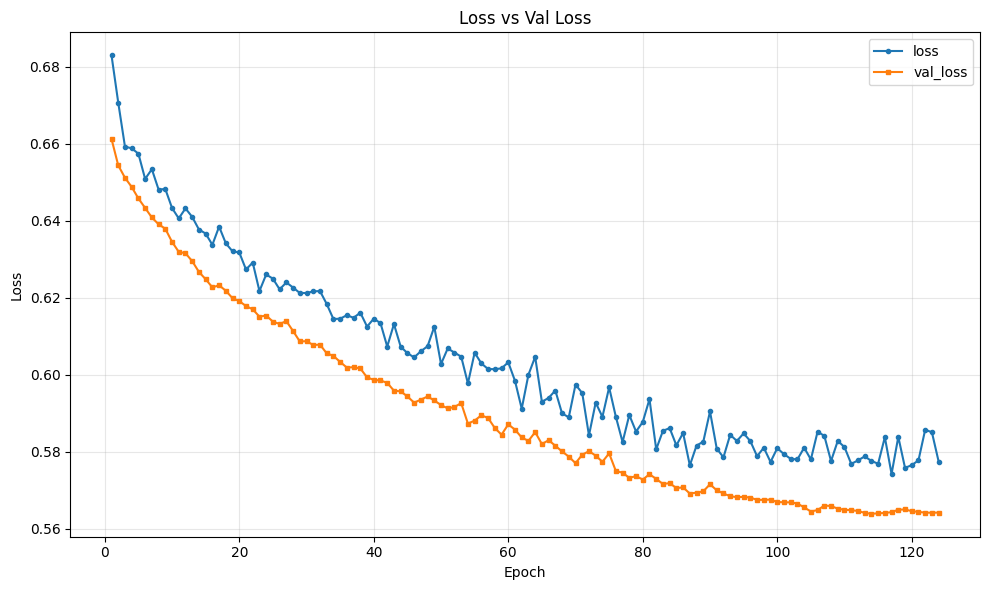

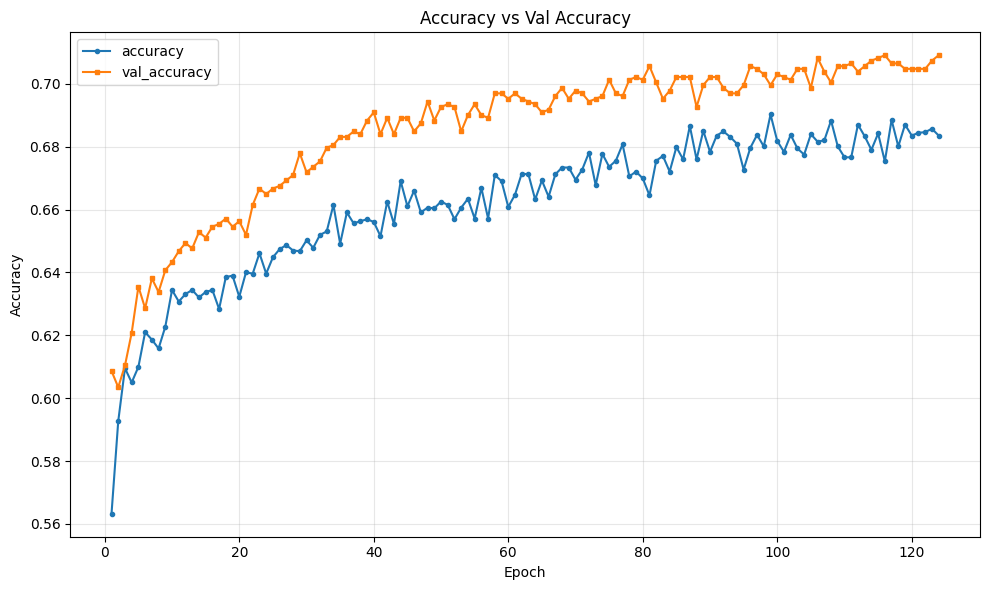

[STEP 8] Plots generated ✅


In [13]:
print("[STEP 8] Plotting training curves...")

# Extract history
hist = history.history  # Dict of metrics
epochs_ran = range(1, len(hist["loss"]) + 1)  # Epoch index

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_ran, hist["loss"], label="loss", marker="o", markersize=3)
plt.plot(epochs_ran, hist["val_loss"], label="val_loss", marker="s", markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Val Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Accuracy
acc_key = "accuracy" if "accuracy" in hist else "binary_accuracy"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_binary_accuracy"

plt.figure(figsize=(10, 6))
plt.plot(epochs_ran, hist[acc_key], label=acc_key, marker="o", markersize=3)
plt.plot(epochs_ran, hist[val_acc_key], label=val_acc_key, marker="s", markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Val Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("[STEP 8] Plots generated ✅")


Cell 13 — Step 9: Save model + save scaler

In [14]:
import os  # For current working directory path

print("[STEP 9] Saving model + scaler...")

# Print current working directory
cwd = os.getcwd()
print(f"[STEP 9] Current working directory: {cwd}")

# Save model in current working directory
model_path = os.path.join(cwd, "band_features_mlp.keras")  # Full path in CWD
model.save(model_path)  # Save model
print(f"[STEP 9] Model saved ✅ -> {model_path}")

# Save scaler in current working directory
scaler_path = os.path.join(cwd, "band_features_scaler.pkl")  # Full path in CWD
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)  # Save scaler object
print(f"[STEP 9] Scaler saved ✅ -> {scaler_path}")

print("[STEP 9] Done ✅")


[STEP 9] Saving model + scaler...
[STEP 9] Current working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/sd-eeg/code/Users/kavinda/Model Training
[STEP 9] Model saved ✅ -> /mnt/batch/tasks/shared/LS_root/mounts/clusters/sd-eeg/code/Users/kavinda/Model Training/band_features_mlp.keras
[STEP 9] Scaler saved ✅ -> /mnt/batch/tasks/shared/LS_root/mounts/clusters/sd-eeg/code/Users/kavinda/Model Training/band_features_scaler.pkl
[STEP 9] Done ✅
